# Customer Churn Prediction Model

#### All the imports required for the steps below

In [1]:
#Regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Models from Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC

#Model Evaluations
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

#Saving the Model
import pickle

In [132]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
np.random.seed(10)

### Data Preparation based on EDA

In [4]:
def baseline_Model_Preparation(filepath):
    '''
    This is a straightforward function for minimal data preparation intended for the baseline model.
    Parameters:
    - filepath (str): The file path of the dataset.

    Returns:
    - pandas.DataFrame: The prepared DataFrame for the baseline model.
    
    '''                               
    data_df = pd.read_csv(filepath)
    
    #.1(customerID)
    data_df = data_df.drop("customerID",axis = 1)

    #.2(gender)
    data_df["gender"] = data_df["gender"].map({'Male': 1, 'Female': 0})
    
    #.3(InternetService)
    data_df["InternetService"] = data_df["InternetService"].map({'Fiber optic': 1, 'DSL': 2,'No' : 0})

    #.4(MultipleLines)
    data_df["MultipleLines"] = data_df["MultipleLines"].map({'Yes': 1, 'No': 0,'No phone service' : 0})

    #.5(Contract)
    data_df["Contract"] = data_df["Contract"].map({'Month-to-month': 0, 'Two year': 2,'One year' : 1})

    #.6(PaymentMethod)
    data_df["PaymentMethod"] = data_df["PaymentMethod"].map({'Electronic check': 0, 'Mailed check': 1,'Bank transfer (automatic)' : 2, 
                                                             'Credit card (automatic)' : 3})

    #.7(Partner,Dependents,PhoneService,PaperlessBilling,Churn)
    YesNoColumns = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
    for i in YesNoColumns:
        data_df[i] = data_df[i].map({'Yes': 1, 'No': 0})

    #.8(OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies)
    YesNoServiceColumns = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV","StreamingMovies"]
    for i in YesNoServiceColumns:
        data_df[i] = data_df[i].map({'Yes': 1, 'No': 0, 'No internet service': 0})

    #.9(TotalCharges)
    data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'], errors='coerce')
    data_df["TotalCharges"] = data_df["TotalCharges"].fillna(data_df["TotalCharges"].mean())
        

    return data_df

In [5]:
data_df = baseline_Model_Preparation("TelcoCustomerChurn.csv")

In [6]:
data_df.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [7]:
data_df.shape

(7043, 20)

In [8]:
data_df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Correlation matrix

In [9]:
corr_data_df = data_df.corr()

In [10]:
corr_data_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
gender,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.008414,0.000863,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,0.000126,-0.011754,-0.005209,-0.014569,0.000048,-0.008612
SeniorCitizen,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.142948,0.032310,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,-0.142554,0.156530,-0.093704,0.220173,0.102395,0.150889
Partner,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,0.142057,-0.000891,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.294806,-0.014877,0.133115,0.096848,0.318812,-0.150448
Dependents,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024526,-0.044590,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,0.243187,-0.111377,0.123844,-0.113890,0.064535,-0.164221
tenure,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.331941,0.030359,0.327203,0.360277,0.360653,0.324221,0.279756,0.286111,0.671607,0.006152,0.340305,0.247900,0.824757,-0.352229


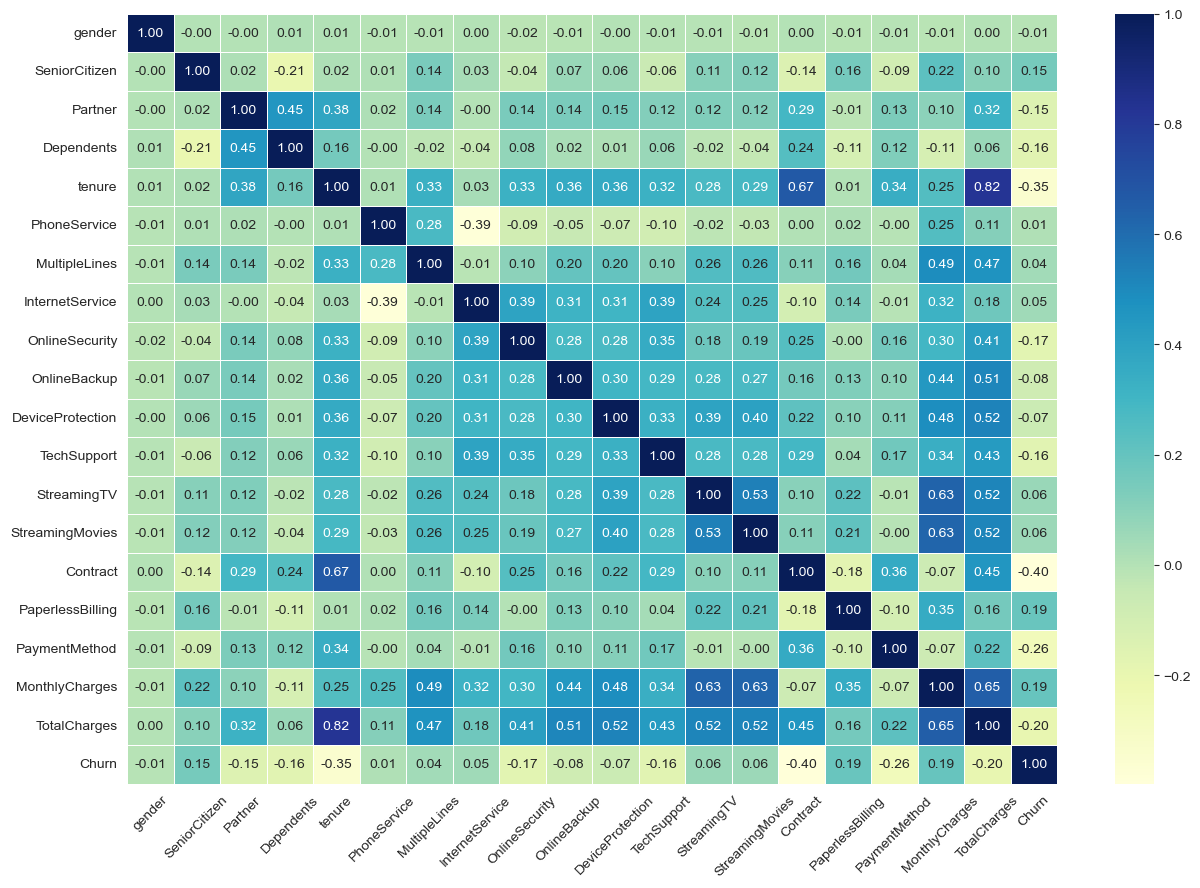

In [137]:
fig,ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_data_df,annot=True,linewidths=0.5,fmt=".2f",cmap = "YlGnBu")
plt.xticks(rotation=45);

### MODEL BUILDING

I am going to build and tune various models because, in this case, many different kinds of models can potentially perform better. The models I will use and evaluate are as follows:
 * RandomForestClassifier
 * LogisticRegression
 * RidgeClassifier
 * LinearSVC"

In [12]:
X = data_df.drop("Churn",axis = 1)
Y = data_df["Churn"]

In [13]:
X.shape

(7043, 19)

In [14]:
Y.shape

(7043,)

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [16]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((4930, 19), (2113, 19), (4930,), (2113,))

##### A function to fit and score various different models simultaneously.

In [17]:
def fit_and_score(models,X_train,X_test,Y_train,Y_test):
    '''
    Train and evaluate the performance of machine learning models.
    
    Parameters:
    - models (dict): A dictionary of Scikit-learn machine learning models.
    - X_train (array-like or pd.DataFrame): Features for training.
    - X_test (array-like or pd.DataFrame): Features for testing.
    - Y_train (array-like or pd.Series): Labels for training.
    - Y_test (array-like or pd.Series): Labels for testing.

    Returns:
    - dict: A dictionary containing the model names as keys and their corresponding evaluation scores.
    '''
    np.random.seed(10)
    model_scores = {}
    for name,model in models.items():
        model.fit(X_train,Y_train)
        model_scores[name] = model.score(X_test,Y_test)

    return model_scores
    

In [18]:
models = {"Logistic Regression": LogisticRegression(max_iter=1000),
              "Random Forest":RandomForestClassifier(),
              "Ridge":RidgeClassifier(),
              "LinearSVC":LinearSVC(max_iter=100000,dual=False)}

In [19]:
%%time
fit_and_score(models,X_train,X_test,Y_train,Y_test)

CPU times: total: 2.7 s
Wall time: 2.15 s


{'Logistic Regression': 0.807382867960246,
 'Random Forest': 0.795551348793185,
 'Ridge': 0.8012304779933743,
 'LinearSVC': 0.8017037387600567}

Using the normal '.score()' method results in similar accuracy scores for all models

##### A function to fit and perform cross-validation on various models simultaneously.

In [20]:
def eval_models_cv(models,X,y,cv):
    '''
    Perform cross-validation for multiple machine learning models.

    Parameters:
    - models (dict): A dictionary containing names as keys and scikit-learn model instances as values.
    - X (array-like): The feature matrix.
    - y (array-like): The target variable.
    - cv (BaseCrossValidator): The cross-validation amount.

    Returns:
    - dict: A dictionary containing model names as keys and their mean cross-validated scores as values.
    '''
    np.random.seed(10)
    model_scores = {}
    for name, model in models.items():
        model_scores[name] = cross_val_score(model,X,Y,cv=cv)

    mean_scores = {}
    for name, scores in model_scores.items():
        mean_scores[name] = np.mean(scores)

    return mean_scores
    
    

In [21]:
%%time
eval_models_cv(models,X,Y,10)

CPU times: total: 19.8 s
Wall time: 20.9 s


{'Logistic Regression': 0.8017897727272727,
 'Random Forest': 0.793692577369439,
 'Ridge': 0.8009348807221148,
 'LinearSVC': 0.8043439716312056}

With cross-validated scores, it is noticeable that the scores are also similar to those obtained using the '.score()' method

Based on the observations above, it appears feasible to employ all four types of models. However, I've chosen to exclude LinearSVC due to potential computational heaviness, especially given the current size of the dataset and features. Additionally, RidgeClassifier is not being considered further because it offers limited parameters for hyperparameter tuning.

#### Using RandomizedSearchCV to further evaluate the remaining two models.

Function to perform RandomizedSearchCV.

In [22]:
def randomized_search_CV(estimator, param_distributions, X_train, Y_train, n_iter, cv, verbose):
    """
    Perform randomized search for hyperparameter tuning.

    Parameters:
    - estimator: Scikit-learn machine learning model.
    - param_distributions (dict): Hyperparameter distributions for randomized search.
    - X_train (array-like or pd.DataFrame): Features for training.
    - Y_train (array-like or pd.Series): Labels for training.
    - n_iter (int): Number of iterations for randomized search.
    - cv (int): Number of cross-validation folds.
    - verbose (int): Verbosity level.

    Returns:
    - RandomizedSearchCV: Trained RandomizedSearchCV object.
    """
    np.random.seed(10)
    rs_model = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distributions,
        refit=True,
        n_iter=n_iter,
        cv=cv,
        verbose=verbose)
    rs_model.fit(X_train, Y_train)

    return rs_model

Function to get a detailed evaluation of models based on different metrics

In [23]:
def detailed_eval_models_cv(model,Y_true,X_test):
    '''
    Evaluate the performance of a machine learning model using various metrics.

    Parameters:
    - model: Trained machine learning model.
    - Y_true (array-like or pd.Series): True labels.
    - X_test (array-like or pd.DataFrame): Features for testing.

    Returns:
    - dict: A dictionary containing accuracy, precision, recall, and F1 score metrics.
    '''

    Y_preds = model.predict(X_test)

    accuracy = accuracy_score(Y_true,Y_preds)
    precision = precision_score(Y_true,Y_preds)
    recall = recall_score(Y_true,Y_preds)
    f1 = f1_score(Y_true,Y_preds)

    metric_dict = {"accuracy" : round(accuracy,8),
                   "precision" : round(precision,8),
                   "recall" : round(recall,8),
                   "f1" : round(f1,8),       }

    print(f"Acc:{accuracy * 100 : .8f} % ")
    print(f"precision:{precision  : .8f}  ")
    print(f"Recall:{recall : .8f}  ")
    print(f"f1_score:{f1  : .8f}  ")

    return metric_dict

#### RandomForestClassifier

In [24]:
RandomForest_model = RandomForestClassifier()

In [25]:
RandomForest_param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

In [26]:
%%time
RandomForest_rs_model = randomized_search_CV(estimator = RandomForest_model,param_distributions = RandomForest_param_distributions,
                     X_train = X_train, Y_train = Y_train, n_iter=10, cv=10, verbose=1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: total: 1min 37s
Wall time: 1min 50s


In [27]:
RandomForest_rs_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 10}

In [28]:
Random_Forest_rs_score = detailed_eval_models_cv(RandomForest_rs_model,Y_test,X_test)

Acc: 80.31235211 % 
precision: 0.65771812  
Recall: 0.52782765  
f1_score: 0.58565737  


#### LogisticRegression

In [29]:
LogReg_model = LogisticRegression()

In [30]:
logReg_param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga','lbfgs'],
    'max_iter': [5000,10000],
    'tol': [1e-4, 1e-3]
}

In [31]:
%%time
LogReg_Rs_model = randomized_search_CV(estimator = LogReg_model,param_distributions = logReg_param_distributions,
                     X_train = X_train, Y_train = Y_train, n_iter=10, cv=10, verbose=1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: total: 1min 32s
Wall time: 1min 24s


In [32]:
LogReg_Rs_model.best_params_

{'tol': 0.0001, 'solver': 'lbfgs', 'max_iter': 10000, 'C': 1}

In [33]:
Logistic_regression_rs_score = detailed_eval_models_cv(LogReg_Rs_model,Y_test,X_test)

Acc: 80.73828680 % 
precision: 0.65690377  
Recall: 0.56373429  
f1_score: 0.60676329  


##### Comparing scores from RandomizedSearchCV of RandomForestClassifier and RandomizedSearchCV of LogisticRegression

Functiom to extract and combine scores from different metrics

In [34]:
def extract_and_combine_scores(dict1,dict2,model_name1,model_name2):
    """
    Extracts and combines evaluation scores from two dictionaries for two different models.

    Parameters:
    - dict1 (dict): The first dictionary containing evaluation scores for model 1.
    - dict2 (dict): The second dictionary containing evaluation scores for model 2.
    - model_name1 (str): Name of the first model.
    - model_name2 (str): Name of the second model.

    Returns:
    - pd.DataFrame: A DataFrame containing combined evaluation scores for both models.
                    Columns include Model, F1 score, Recall score, Accuracy score, and Precision score.
    """
    
    f1_scores1 = dict1["f1"]
    f1_scores2 = dict2["f1"]
    recall_scores1 = dict1["recall"]
    recall_scores2 = dict2["recall"]
    precision_scores1 = dict1["precision"]
    precision_scores2 = dict2["precision"]
    accuracy_scores1 = dict1["accuracy"]
    accuracy_scores2 = dict2["accuracy"]

    compare_scores_df = pd.DataFrame({
    'Model': [model_name1, model_name2],
    'F1 score': [f1_scores1, f1_scores2],
    'Recall score' :[recall_scores1,recall_scores2],
    'Accuracy score':[accuracy_scores1,accuracy_scores2],
    'Precision score':[precision_scores1,precision_scores2]
    })

    return compare_scores_df

In [35]:
tempdf = extract_and_combine_scores(Logistic_regression_rs_score,Random_Forest_rs_score,'LogisticRegression','RandomForest')

In [36]:
tempdf

,Model,F1 score,Recall score,Accuracy score,Precision score
0,LogisticRegression,0.606763,0.563734,0.807383,0.656904
1,RandomForest,0.585657,0.527828,0.803124,0.657718


Function to visualize the comparison.

In [37]:
def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.8f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 4), textcoords='offset points')

In [157]:
def compare_graphs(df,title):
    fig,ax = plt.subplots(nrows = 2,ncols = 2,figsize = (8,9),gridspec_kw={'hspace': 0.3, 'wspace': 0.5})
    plt.figure(figsize=(4, 4))
    fig.suptitle(title, fontsize=16)
    sns.barplot(x='Model', y='F1 score',hue = 'Model', data=df,palette=["teal", "tomato"],ax = ax[0,0],legend=False);
    annotate_bars(ax[0, 0])
    sns.barplot(x='Model', y='Recall score',hue = 'Model', data=df,palette=["teal", "tomato"],ax = ax[0,1])
    annotate_bars(ax[0, 1])
    sns.barplot(x='Model', y='Accuracy score',hue = 'Model', data=df,palette=["teal", "tomato"],ax = ax[1,0])
    annotate_bars(ax[1, 0])
    sns.barplot(x='Model', y='Precision score',hue = 'Model', data=df,palette=["teal", "tomato"],ax = ax[1,1])
    annotate_bars(ax[1, 1])

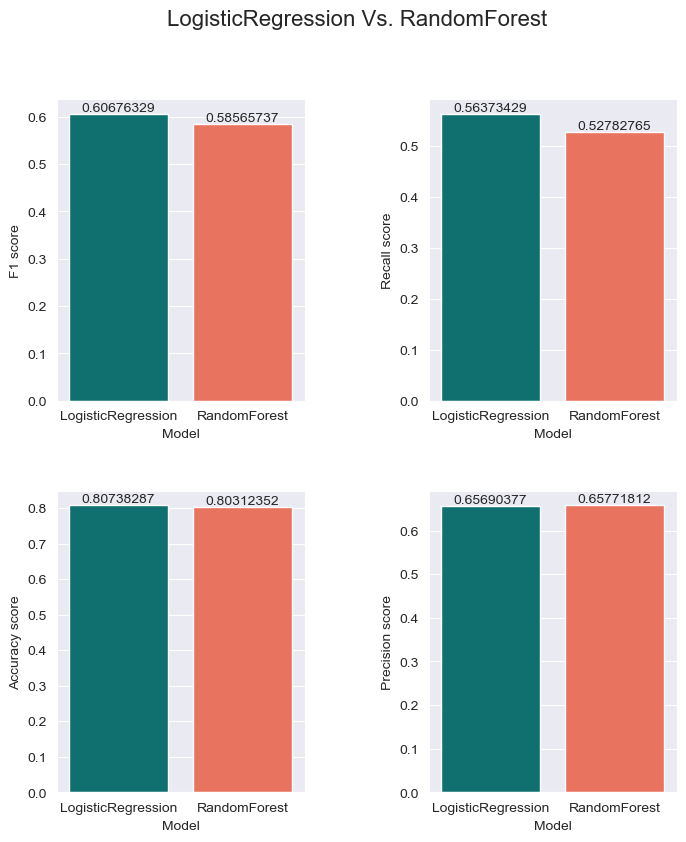

<Figure size 400x400 with 0 Axes>

In [158]:
compare_graphs(tempdf,"LogisticRegression Vs. RandomForest")

It is evident that LogisticRegression consistently outperforms across various metrics. Considering its superior performance, I have decided to move forward with LogisticRegression for further analysis

### Hyperparameters Tuning

#### Baseline Model

In [40]:
baseline_model = LogisticRegression(max_iter=5000)
baseline_model.fit(X_train,Y_train)
baseline_metrics = detailed_eval_models_cv(baseline_model,Y_test,X_test)

Acc: 80.73828680 % 
precision: 0.65690377  
Recall: 0.56373429  
f1_score: 0.60676329  


#### Utilizing GridSearchCV to enhance the model.

Function to perform GridSearchCV.

In [41]:
def grid_search_CV(estimator, param_grid, X_train, Y_train, cv, verbose,n_jobs):
    """
    Perform randomized search for hyperparameter tuning.

    Parameters:
    - estimator: Scikit-learn machine learning model.
    - param_grid (dict): Hyperparameter grid for grid search.
    - X_train (array-like or pd.DataFrame): Features for training.
    - Y_train (array-like or pd.Series): Labels for training.
    - cv (int): Number of cross-validation folds.
    - verbose (int): Verbosity level.
    - n_jobs (int or None, optional): Number of CPU threads to use during cross-validation

    Returns:
    - GridSearchCV: Trained GridSearchCV object.
    """
    np.random.seed(10)
    gs_model = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        refit=True,
        cv=cv,
        verbose=verbose,
        n_jobs=n_jobs)
    
    gs_model.fit(X_train, Y_train)

    return gs_model

#### Selecting MAX_ITER

In [42]:
logReg_param_grid_MaxIter = {
    'max_iter': [50,100,500,1000,5000]
}

In [43]:
%%time
LogReg_Gs_model=grid_search_CV(estimator = LogReg_model,param_grid = logReg_param_grid_MaxIter,
                     X_train = X_train, Y_train = Y_train,cv=10, verbose=1,n_jobs = -1)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
CPU times: total: 984 ms
Wall time: 7.55 s


In [44]:
LogReg_Gs_model.best_params_

{'max_iter': 500}

MAX_ITER = 500

In [45]:
max_iter_metrics = detailed_eval_models_cv(LogReg_Gs_model,Y_test,X_test)

Acc: 80.73828680 % 
precision: 0.65690377  
Recall: 0.56373429  
f1_score: 0.60676329  


Comparing the baseline model with an optimized max_iter value.

In [46]:
tempdf1 = extract_and_combine_scores(baseline_metrics,max_iter_metrics,'Baseline','Max_iter')

In [47]:
tempdf1

,Model,F1 score,Recall score,Accuracy score,Precision score
0,Baseline,0.606763,0.563734,0.807383,0.656904
1,Max_iter,0.606763,0.563734,0.807383,0.656904


#### Selecting SOLVER and PENALTY

In [48]:
logReg_param_grid_SolPen = {
    'penalty': ['l2',None],
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
    'max_iter': [500]
}

In [49]:
%%time
LogReg_Gs_model1=grid_search_CV(estimator = LogReg_model,param_grid = logReg_param_grid_SolPen,
                     X_train = X_train, Y_train = Y_train,cv=10, verbose=1,n_jobs = -1)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
CPU times: total: 984 ms
Wall time: 4.55 s


In [50]:
LogReg_Gs_model1.best_params_

{'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

In [51]:
solver_pen_metrics = detailed_eval_models_cv(LogReg_Gs_model1,Y_test,X_test)

Acc: 80.73828680 % 
precision: 0.65690377  
Recall: 0.56373429  
f1_score: 0.60676329  


In [52]:
tempdf2 = extract_and_combine_scores(baseline_metrics,solver_pen_metrics,'Baseline','Solver_Pen')

In [53]:
tempdf2

,Model,F1 score,Recall score,Accuracy score,Precision score
0,Baseline,0.606763,0.563734,0.807383,0.656904
1,Solver_Pen,0.606763,0.563734,0.807383,0.656904


In [54]:
logReg_param_grid_SolPen1 = {
    'penalty': ['l2','l1'],
    'solver': ['liblinear'],
    'max_iter': [500]
}

In [55]:
%%time
LogReg_Gs_model2=grid_search_CV(estimator = LogReg_model,param_grid = logReg_param_grid_SolPen1,
                     X_train = X_train, Y_train = Y_train,cv=10, verbose=1,n_jobs = -1)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
CPU times: total: 266 ms
Wall time: 331 ms


In [56]:
LogReg_Gs_model2.best_params_

{'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}

In [57]:
solver_pen_metrics1 = detailed_eval_models_cv(LogReg_Gs_model2,Y_test,X_test)

Acc: 80.35967818 % 
precision: 0.64791667  
Recall: 0.55834829  
f1_score: 0.59980714  


In [58]:
tempdf3 = extract_and_combine_scores(baseline_metrics,solver_pen_metrics1,'Solver_Pen','Solver_Pen_liblinear')

In [59]:
tempdf3

,Model,F1 score,Recall score,Accuracy score,Precision score
0,Solver_Pen,0.606763,0.563734,0.807383,0.656904
1,Solver_Pen_liblinear,0.599807,0.558348,0.803597,0.647917


Not using liblinear because of lower scores.

#### Selecting C AND Tol

In [60]:
logReg_param_grid_CandTol1 = {
    'C': np.linspace(0.5,1.6,100), 
    'tol': [1e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2],
    'max_iter': [500],
    'penalty': ['l2'],
    'solver': ['lbfgs']    
}

In [61]:
%%time
LogReg_Gs_model3=grid_search_CV(estimator = LogReg_model,param_grid = logReg_param_grid_CandTol1,
                     X_train = X_train, Y_train = Y_train,cv=10, verbose=1,n_jobs = -1)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits
CPU times: total: 30.6 s
Wall time: 2min 43s


In [62]:
LogReg_Gs_model3.best_params_

{'C': 1.3666666666666667,
 'max_iter': 500,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 1e-05}

In [63]:
c_tol_metrics = detailed_eval_models_cv(LogReg_Gs_model3,Y_test,X_test)

Acc: 80.78561287 % 
precision: 0.65762004  
Recall: 0.56552962  
f1_score: 0.60810811  


In [64]:
tempdf4 = extract_and_combine_scores(baseline_metrics,c_tol_metrics,'Baseline','c_tol')

In [65]:
tempdf4

,Model,F1 score,Recall score,Accuracy score,Precision score
0,Baseline,0.606763,0.563734,0.807383,0.656904
1,c_tol,0.608108,0.565530,0.807856,0.657620


#### Selecting Multiclass and fit intercept

In [66]:
logReg_param_grid_MulFit = {
    'C': [1.3666666666666667], 
    'tol': [1e-05],
    'max_iter': [500],
    'penalty': ['l2'],
    'solver': ['lbfgs'] ,
    'fit_intercept' : [True,False],
    'multi_class' : ['auto', 'ovr', 'multinomial']
}

In [67]:
%%time
LogReg_Gs_model4=grid_search_CV(estimator = LogReg_model,param_grid = logReg_param_grid_MulFit,
                     X_train = X_train, Y_train = Y_train,cv=10, verbose=1,n_jobs = -1)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
CPU times: total: 906 ms
Wall time: 1.86 s


In [68]:
LogReg_Gs_model4.best_params_

{'C': 1.3666666666666667,
 'fit_intercept': True,
 'max_iter': 500,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 1e-05}

In [69]:
Multiclass_fit_metrics = detailed_eval_models_cv(LogReg_Gs_model4,Y_test,X_test)

Acc: 80.78561287 % 
precision: 0.65762004  
Recall: 0.56552962  
f1_score: 0.60810811  


In [70]:
tempdf5 = extract_and_combine_scores(baseline_metrics,Multiclass_fit_metrics,'Baseline','Multiclass_fit')

In [71]:
tempdf5

,Model,F1 score,Recall score,Accuracy score,Precision score
0,Baseline,0.606763,0.563734,0.807383,0.656904
1,Multiclass_fit,0.608108,0.565530,0.807856,0.657620


#### Selecting Class weight

In [72]:
# 'class_weight':[{0:1, 1:1},{0:1, 1:2},{0:1, 1:3},'balanced',None]

In [73]:
logReg_param_grid_weight = {
    'C': [1.3666666666666667], 
    'tol': [1e-05],
    'max_iter': [500],
    'penalty': ['l2'],
    'solver': ['lbfgs'] ,
    'fit_intercept' : [True,],
    'multi_class' : ['auto'],
    'class_weight':[{0:1, 1:2},{0:1, 1:3},'balanced',None]
}

In [74]:
%%time
LogReg_Gs_model5=grid_search_CV(estimator = LogReg_model,param_grid = logReg_param_grid_weight,
                     X_train = X_train, Y_train = Y_train,cv=10, verbose=1,n_jobs = -1)


Fitting 10 folds for each of 4 candidates, totalling 40 fits
CPU times: total: 656 ms
Wall time: 996 ms


In [75]:
LogReg_Gs_model5.best_params_

{'C': 1.3666666666666667,
 'class_weight': None,
 'fit_intercept': True,
 'max_iter': 500,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 1e-05}

In [76]:
class_weight_metrics = detailed_eval_models_cv(LogReg_Gs_model5,Y_test,X_test)

Acc: 80.78561287 % 
precision: 0.65762004  
Recall: 0.56552962  
f1_score: 0.60810811  


In [77]:
tempdf6 = extract_and_combine_scores(baseline_metrics,class_weight_metrics,'Baseline','FinalModel')

In [78]:
tempdf6

,Model,F1 score,Recall score,Accuracy score,Precision score
0,Baseline,0.606763,0.563734,0.807383,0.656904
1,FinalModel,0.608108,0.565530,0.807856,0.657620


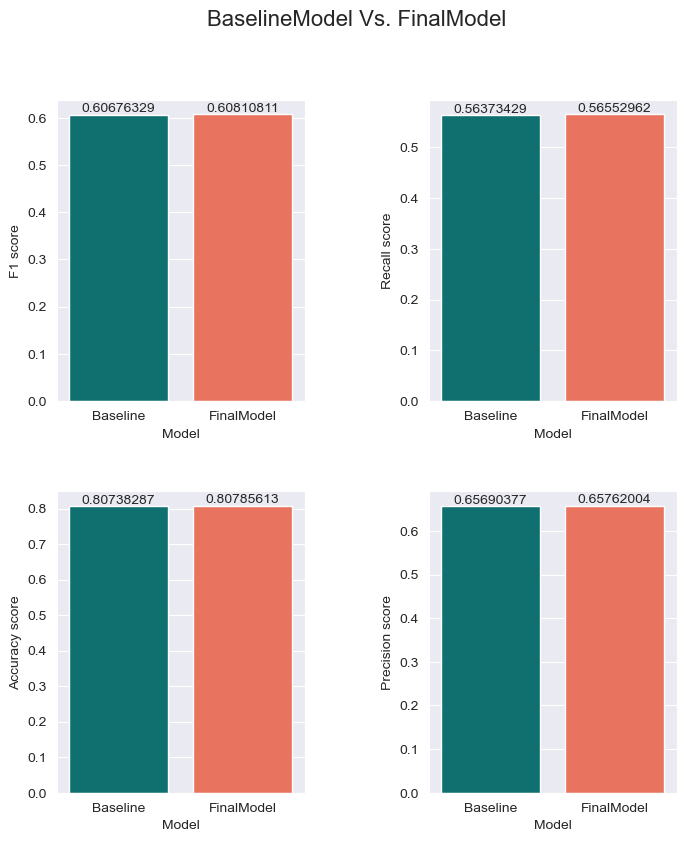

<Figure size 400x400 with 0 Axes>

In [163]:
compare_graphs(tempdf6,title = "BaselineModel Vs. FinalModel")

As we can see, there is a slight improvement. The default parameters of Logistic Regression seem to be well-suited for this current dataset, resulting in similar results after hyperparameter tuning.

## Final Model

##### Best parameters for this model on this dataset according to hyperparameter tuning

In [80]:
LogReg_Gs_model5.best_params_

{'C': 1.3666666666666667,
 'class_weight': None,
 'fit_intercept': True,
 'max_iter': 500,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 1e-05}

In [81]:
final_model = LogisticRegression(C= 1.3666666666666667, class_weight= None, fit_intercept= True, max_iter= 500,
                        multi_class= 'auto', penalty= 'l2', solver= 'lbfgs', tol= 1e-05)

In [82]:
final_model.fit(X_train,Y_train)

LogisticRegression(C=1.3666666666666667, max_iter=500, tol=1e-05)

In [83]:
Y_preds = final_model.predict(X_test)

In [84]:
Y_preds

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [85]:
Y_preds.shape

(2113,)

In [86]:
Y_test.head()

6418    0
1948    1
4497    0
66      0
1705    0
Name: Churn, dtype: int64

In [87]:
Y_test.shape

(2113,)

In [88]:
Y_probs = final_model.predict_proba(X_test)

In [89]:
Y_probs.shape

(2113, 2)

In [90]:
Y_probs_positive = Y_probs[:,1]

In [91]:
Y_probs_positive.shape

(2113,)

##### Evaluating our tuned machine learning model beyond accuracy
* ROC curve and AUC score
* Confusion Matrix
* Classification Report
* Precision
* Recall
* F1 score

##### AUC/ROC Curve

Area under curve :  0.8417453951346037 



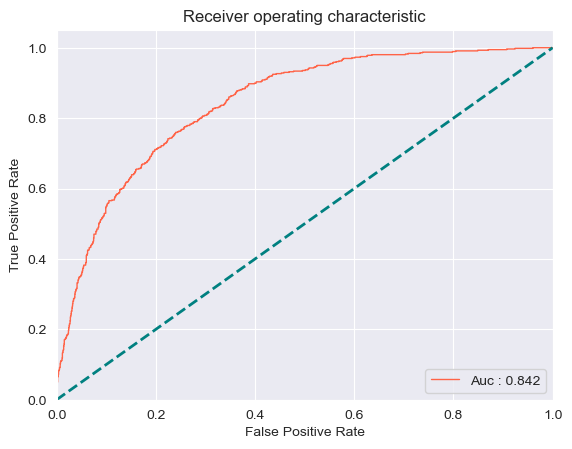

In [166]:
model_roc_auc = roc_auc_score(Y_test,Y_probs_positive) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(Y_test,Y_probs_positive)

plt.plot(fpr, tpr, color='tomato', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='teal', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

##### Confusion Matrix

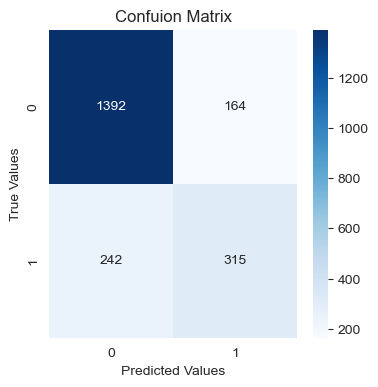

In [169]:
conf_matrix = confusion_matrix(Y_test,Y_preds)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values');

##### Classification Report

In [94]:
C_report = classification_report(Y_test,Y_preds)

In [95]:
print(C_report)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1556
           1       0.66      0.57      0.61       557

    accuracy                           0.81      2113
   macro avg       0.75      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



##### Accuracy (with cross validation)

In [96]:
%%time
cv_accuracy = cross_val_score(final_model,X,Y,cv=100,scoring='accuracy')
cv_accuracy = np.mean(cv_accuracy)

CPU times: total: 49.7 s
Wall time: 13.6 s


In [97]:
cv_accuracy

0.8043319919517102

##### Precision (with cross validation)


In [98]:
%%time
cv_precision = cross_val_score(final_model,X,Y,cv=100,scoring='precision')
cv_precision = np.mean(cv_precision)

CPU times: total: 57.6 s
Wall time: 11.9 s


In [99]:
cv_precision

0.6605964655829208

##### Recall (with cross validation)

In [100]:
%%time
cv_recall = cross_val_score(final_model,X,Y,cv=100,scoring='recall')
cv_recall = np.mean(cv_recall)

CPU times: total: 58.3 s
Wall time: 11.6 s


In [101]:
cv_recall

0.548859649122807

##### F1 score (with cross validation)

In [102]:
%%time
cv_f1 = cross_val_score(final_model,X,Y,cv=100,scoring='f1')
cv_f1 = np.mean(cv_f1)

CPU times: total: 58.1 s
Wall time: 11.5 s


In [103]:
cv_f1

0.5942062239998697

#### Visualizing cross-validated metrics

In [104]:
cv_metrics = pd.DataFrame({"Accuracy":cv_accuracy,
                           "Precision":cv_precision,
                           "Recall":cv_recall,
                           "f1 score":cv_f1},  
                           index = [0]
)

In [105]:
cv_metrics

,Accuracy,Precision,Recall,f1 score
0,0.804332,0.660596,0.54886,0.594206


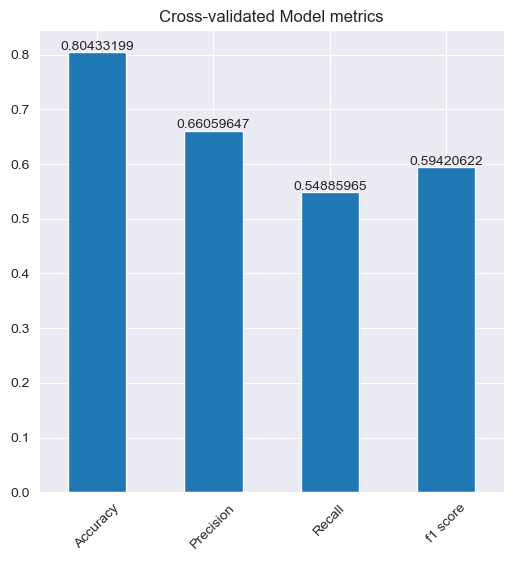

In [172]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6))
cv_metrics.T.plot.bar(title = "Cross-validated Model metrics",legend = False,ax=ax)
annotate_bars(ax)
plt.xticks(rotation=45);

### Feature Importance

In [107]:
final_model.coef_

array([[-4.80025780e-02,  1.57834189e-01,  6.27713625e-02,
        -6.52557389e-02, -4.72309172e-02, -1.07422203e+00,
         8.86035383e-02,  5.59535943e-03, -6.45210221e-01,
        -3.95882779e-01, -1.20019177e-01, -5.06997944e-01,
        -1.33525311e-01,  3.28540642e-02, -7.45915373e-01,
         4.46712816e-01, -1.55712906e-01,  3.15644212e-02,
         1.89365765e-04]])

In [108]:
feature_dict = dict(zip(data_df.columns,list(final_model.coef_[0])))

In [109]:
feature_dict

{'gender': -0.0480025779838259,
 'SeniorCitizen': 0.1578341889885679,
 'Partner': 0.06277136252023839,
 'Dependents': -0.06525573887427565,
 'tenure': -0.04723091721561297,
 'PhoneService': -1.074222031435827,
 'MultipleLines': 0.08860353829069947,
 'InternetService': 0.005595359428002272,
 'OnlineSecurity': -0.6452102209066667,
 'OnlineBackup': -0.3958827791814593,
 'DeviceProtection': -0.12001917700746956,
 'TechSupport': -0.5069979438498847,
 'StreamingTV': -0.13352531077391375,
 'StreamingMovies': 0.032854064193702355,
 'Contract': -0.7459153731196185,
 'PaperlessBilling': 0.44671281648073763,
 'PaymentMethod': -0.15571290569764495,
 'MonthlyCharges': 0.0315644211594999,
 'TotalCharges': 0.0001893657653783097}

##### Visualizing feature importance

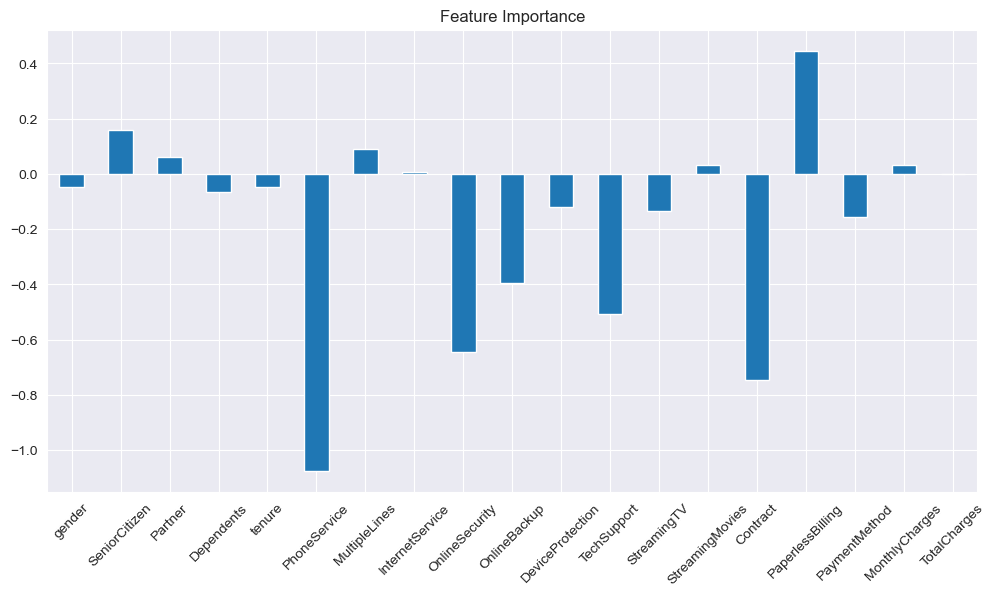

In [177]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (12,6))
feature_df = pd.DataFrame(feature_dict,index= [0])
feature_df.T.plot.bar(title="Feature Importance",legend = False,ax=ax)
plt.xticks(rotation=45);

#### Checking the model's performance on train data itself

In [111]:
final_model.fit(X_train,Y_train)

LogisticRegression(C=1.3666666666666667, max_iter=500, tol=1e-05)

In [112]:
Y_train_preds = final_model.predict(X_train)

In [113]:
train_accuracy = accuracy_score(Y_train,Y_train_preds)

In [114]:
train_precision = precision_score(Y_train,Y_train_preds)

In [115]:
train_recall =  recall_score(Y_train,Y_train_preds)

In [116]:
train_f1 = f1_score(Y_train,Y_train_preds)

In [117]:
cv_metrics1 = pd.DataFrame({"Accuracy" : train_accuracy,
                           "Precision" : train_precision,
                           "Recall" : train_recall,
                           "f1 score" : train_f1},  
                           index = [0]
)

In [118]:
cv_metrics1

,Accuracy,Precision,Recall,f1 score
0,0.808114,0.668819,0.552591,0.605175


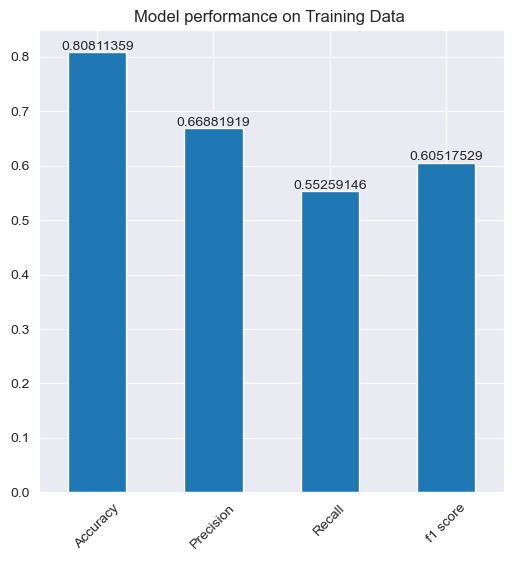

In [179]:
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6))
cv_metrics1.T.plot.bar(title = "Model performance on Training Data ",legend = False,ax=ax)
annotate_bars(ax)
plt.xticks(rotation=45);

As we can see that the performance of the model on test data is similar to training data. So, we can conclude that there is no overfitting and underfitting.

### Saving model

In [120]:
pickle.dump(final_model, open('model.pkl','wb'))